# Archie Creek Fire Analysis

The Archie Creek Fire was a large wildfire that consumed nearly 100,000 acres of western Oregon in its first 24 hours on Setember 8th, 2020. It took over a month for firefighters to corral the fire when it was 100% contained on October 31. This project uses satellite imagery to perform statistical observations and analysis on this fire.

We will be using Sentinel-2 data in this analysis, downloaded from https://browser.dataspace.copernicus.eu/.
The Copernicus Sentinel-2 is a pair of identical satellites obiting the earth, constantly gathering images using its high-resolution multispectral imager, which has 13 bands for detailed info on land and vegetation. 

Each of the rasters used in this analysis is a composite of 4 rasters downloaded from Copernicus, and stitched together using ArcGis Pro's raster tools. 4 rasters have to be used for each iteration of the fire because the fire is located in a space in the middle of 4 of the Sentinel's pictures. 

To start this project, we download the required rasters from Copernicus for before the fire, during the fire, and after the fire. The respective rasters are stitched together, and imported into our database. We then import the needed libraries

In [1]:
from datetime import datetime
import warnings

from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arcpy
from arcpy.ia import *

from arcpy.sa import Raster

import arcgis
from arcgis import GIS
from arcgis.raster.functions import *
from arcgis.mapping import MapImageLayer
from arcgis.geoenrichment import enrich
from arcgis.raster.analytics import create_image_collection
from arcgis.raster.analytics import list_datastore_content

gis= GIS('home')

We then import the downloaded rasters, and create a polygon that will represent the specific area we are looking at. The aoi is just a rectangle of coordinates that encompass the area of the fire

In [ ]:
#Importing rasters
beforeFireRaster = arcpy.Raster("E:\\ArcGis\\BootcampGISProjects\\2-awsAssessments\\FinalProject\\FinalProject\\BeforeFireHQ.tif")
duringFireRaster = arcpy.Raster("E:\\ArcGis\\BootcampGISProjects\\2-awsAssessments\\FinalProject\\FinalProject\\DuringFireHQ.tif")
afterFireRaster = arcpy.Raster("E:\\ArcGis\\BootcampGISProjects\\2-awsAssessments\\FinalProject\\FinalProject\\AfterFireHQ.tif")

#Setting the AOI of our project
spatialRef = arcpy.SpatialReference(32610)
featureCoordinates = [[480197.497360899,4822364.72134192],[531410.349786604,4822364.72134192],[531410.349786604,4785217.14704677],[480197.497360899,4785217.14704677]]
coordinatesArray = arcpy.Array([arcpy.Point(*coords) for coords in featureCoordinates])
coordinatesArray.append(coordinatesArray[0])
AOIpolygon = arcpy.Polygon(coordinatesArray, spatialRef)

aoi = {'spatialReference': {'wkid': 32610},
 'xmax': 531410.349786604,
 'xmin': 480197.497360899,
 'ymax': 4822364.72134192,
 'ymin': 4785217.14704677}

#Clipping Rasters
beforeFire_clipped_raster = arcpy.ia.Clip(beforeFireRaster, AOIpolygon)
#beforeFire_clipped_raster.save()
duringFire_clipped_raster = arcpy.ia.Clip(duringFireRaster, AOIpolygon)
#duringFire_clipped_raster.save()
afterFire_clipped_raster = arcpy.ia.Clip(afterFireRaster, AOIpolygon)
#afterFire_clipped_raster.save()

# Visual Assessment
First, we take a look at the area before the fire. Not much going on. We can see places being used for crops, alot of green vegetation, and a couple small pockets of water.

*Note: Raster is much higher quality before getting clipped. I tried many different clipping options, but could not seem to find one that preserves raster quality. This analysis can be performed on the original rasters that are higher quality for a more accurate analysis, but for the purpose of this notebook I am performing the analysis on the smaller, lesser quality rasters*

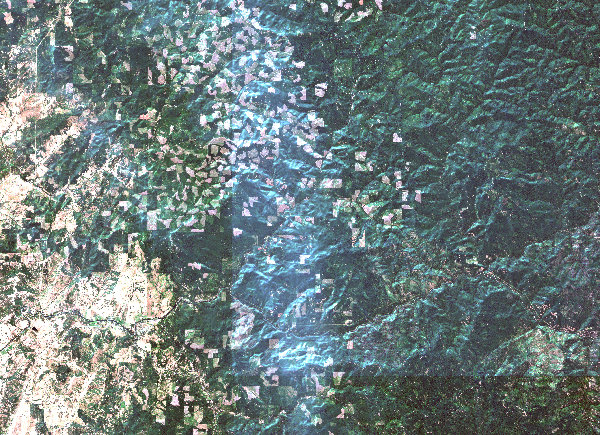

In [3]:
BeforeFireTrueColor = arcpy.ia.Render(beforeFire_clipped_raster, rendering_rule={'bands': [4,3,2], 'numberOfStandardDeviations': 2, 'gamma': [1.0,1.0,1.0]})
BeforeFireTrueColor

# Visualize burning area
We now take a look at the area while the fire was burning. We can see the burning area below, but you can't see much in the true color image with the smoke covering it.

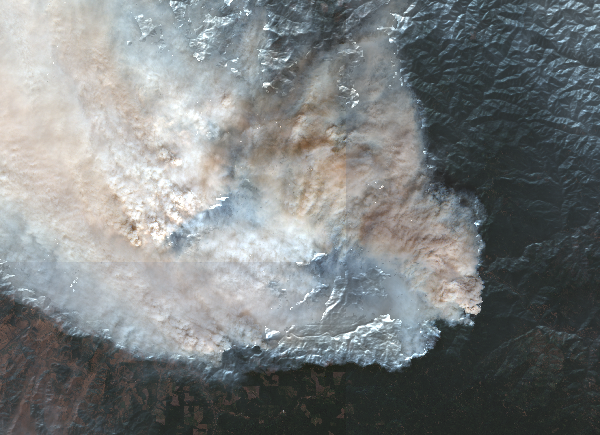

In [4]:
DuringFireTrueColor = arcpy.ia.Render(duringFire_clipped_raster, rendering_rule={'bands': [4,3,2], 'numberOfStandardDeviations': 2, 'gamma': [1.0,1.0,1.0]})
DuringFireTrueColor

We can't gather much information or see very much when looking at the true color, so we will instead look at the image further into the SWIR range of the electromagnetic spectrum, where the smoke and haze from the fire is less visible

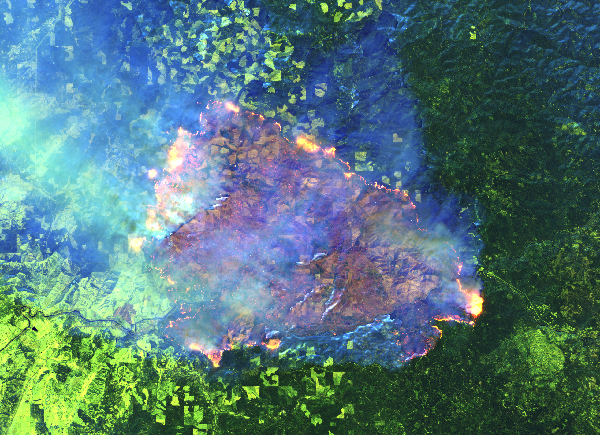

In [5]:
DuringFireSWIR = arcpy.ia.Render(duringFire_clipped_raster, rendering_rule={'bands': [12,11,4], 'numberOfStandardDeviations': 2, 'gamma': [1.0,1.0,1.0]})
DuringFireSWIR

# Quantitative Assessment
Next we perform some analysis on the rasters. We are interested in the (NBR) or Normalized Burn Ratio. This number can be used to dertermine the severity of burnt areas left from fires.

The formula for the NBR is very similar to that of NDVI except that it uses near-infrared band 9 and the short-wave infrared band 13: 

$(B9 - B13) / (B9 + B13 + WS)$. 

The WS parameter is used for water suppression, and is typically 2000.
For our given area, NBR is calculated from an image taken before to the burn (within a week before the burn) and a second NBR is calculated for an image following the burn (within a week of the burning completely stopping). Burn extent and severity is judged by taking the difference between these two index layers:

NBR Diff = NBRBeforeFire - NBRAfterFire

The meaning of the ∆NBR values can vary by scene, and different interpretations can be taken to extract varying data types and conclusions. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:

| ∆NBR | Burn Severity |
|----------|---------------|
| 0.1 to 0.27 | Low severity burn |
| 0.27 to 0.44 | Medium severity burn |
| 0.44 to 0.66 | Moderate severity burn |
| > 0.66 | High severity burn |

# Use Band Arithmetic and Map Algebra
We start to perform raster analysis on the raw pixel value, so we create a new layer based on the formulas above that calculates the NBR difference, and displays it as a colormap showing fire burn intensity levels.

In [6]:
nbrBeforeFire = arcpy.sa.BandArithmetic(beforeFire_clipped_raster, "(B9 - B13) / (B9 + B13 + 2000)",0)
nbrAfterFire = arcpy.sa.BandArithmetic(afterFire_clipped_raster, "(B9 - B13) / (B9 + B13 + 2000)",0)
nbrDiff = nbrBeforeFire - nbrAfterFire

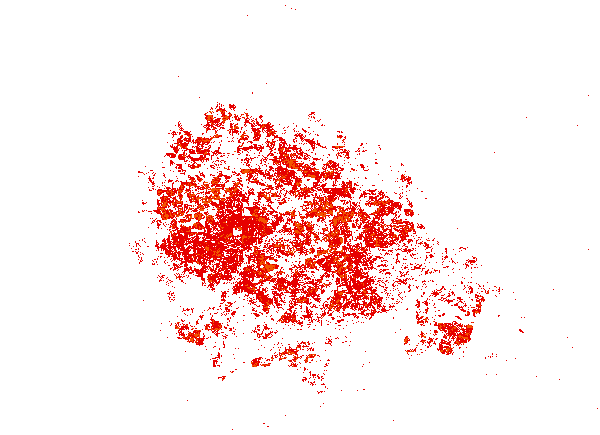

In [7]:
BurntAreas = Colormap(Remap(nbrDiff,
                            input_ranges=[0.19, 0.27,  #low severity
                                          0.27, 0.44,  #Medium severity
                                          0.44, 0.66,  #Moderate severity
                                          0.66, 1.00], #High severity
                            output_values=[1,2,3,4],
                            no_data_ranges=[-1, 0.1]),
                      colormap=[[4, 0xFF, 0xC3, 0], [3, 0xFA, 0x8E, 0], [2, 0xF2, 0x55, 0], [1, 0xE6, 0,    0]])
BurntAreas

# Visualize burnt areas
Next we can visually see the burned areas, as calculated by the NBR, overlayed with the area of the burning fire. 

*Note: Could not get gis.map() to work, so i've included screenshots of these rasters rendered together on an ArcGis Map, which look the same as rendering them here in the notebook*

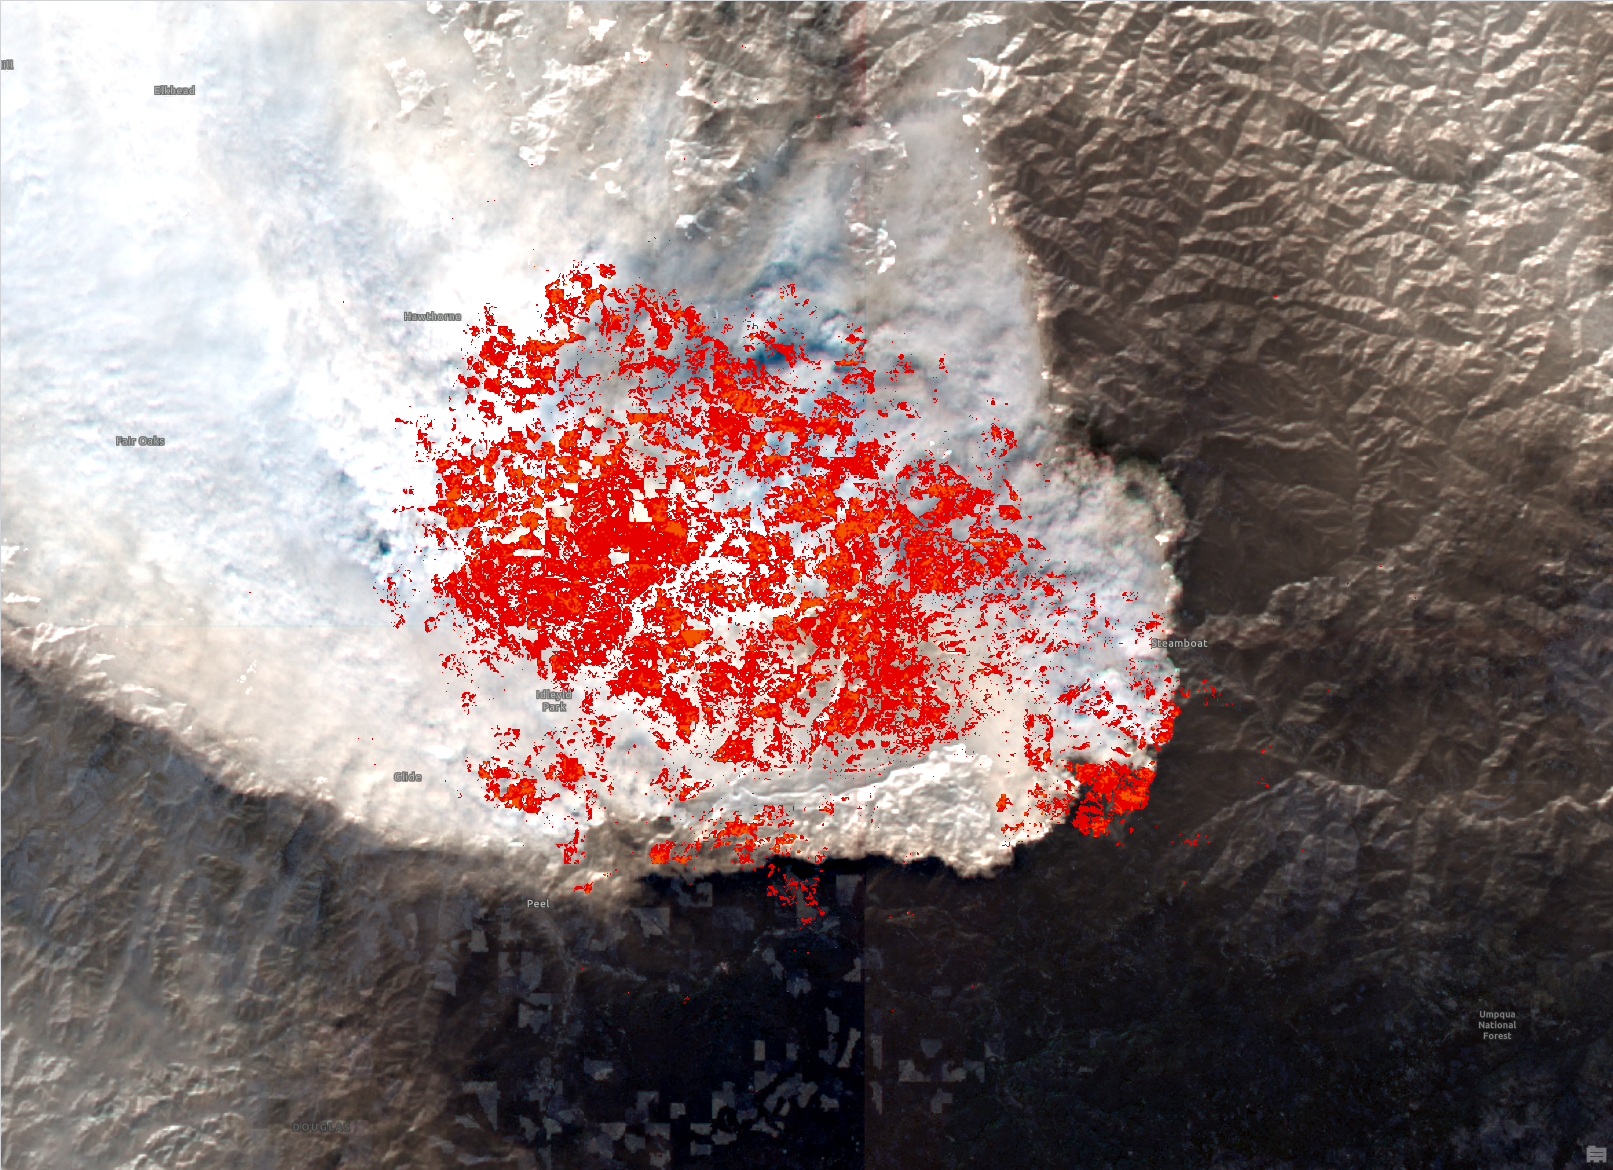

In [8]:
viewFireMap = {'title': 'fireMap', 'tags': 'fire-map', 'snippet': 'Archie Creek fire burnt areas'}

#firemap = gis.map()
#firemap.content.add(DuringFireTrueColor)
#iremap.content.add(BurntAreas)
#firemap.extent = aoi
#firemap

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "E:\\ArcGis\\BootcampGISProjects\\2-awsAssessments\\Final Project Data\Data\\"
Image(filename = PATH + "DuringFireColorMapLayer.PNG",width=1000)

# Raster to Feature layer conversion
Here we create a feature layer out of the burnt area that we calculated above. This is another section where the analysis had to be done in ArcGIS Pro due to the arcpy tools not functioning correctly. The two tools below create a feature layer that contains polygons created from the burnt areas shown from the nbr equations. This feature layer is then put through the "Pairwise Buffer" ArcGIS analysis tool putting buffers of 150 meters around all of the polygons. Then the layer is put through the "Dissolve Boundaries" tool to create bigger polygons that represent the fire. Now, we want a fire boundary and layer that represents the bulk of the fire, so we still need to remove the little points of data that are not part of the main bulk.

To remove these little unneeded parts, we remove all polygons that have an area below a threshold, and then visually remove any polygons that are seperated from the main bulk.

We now have a feature layer that has a list of polygons that represent the fire.

*Note: Like before, gis.map() would not function properly, so I rendered the layer in an ArcGis map and put a screenshot of it below*

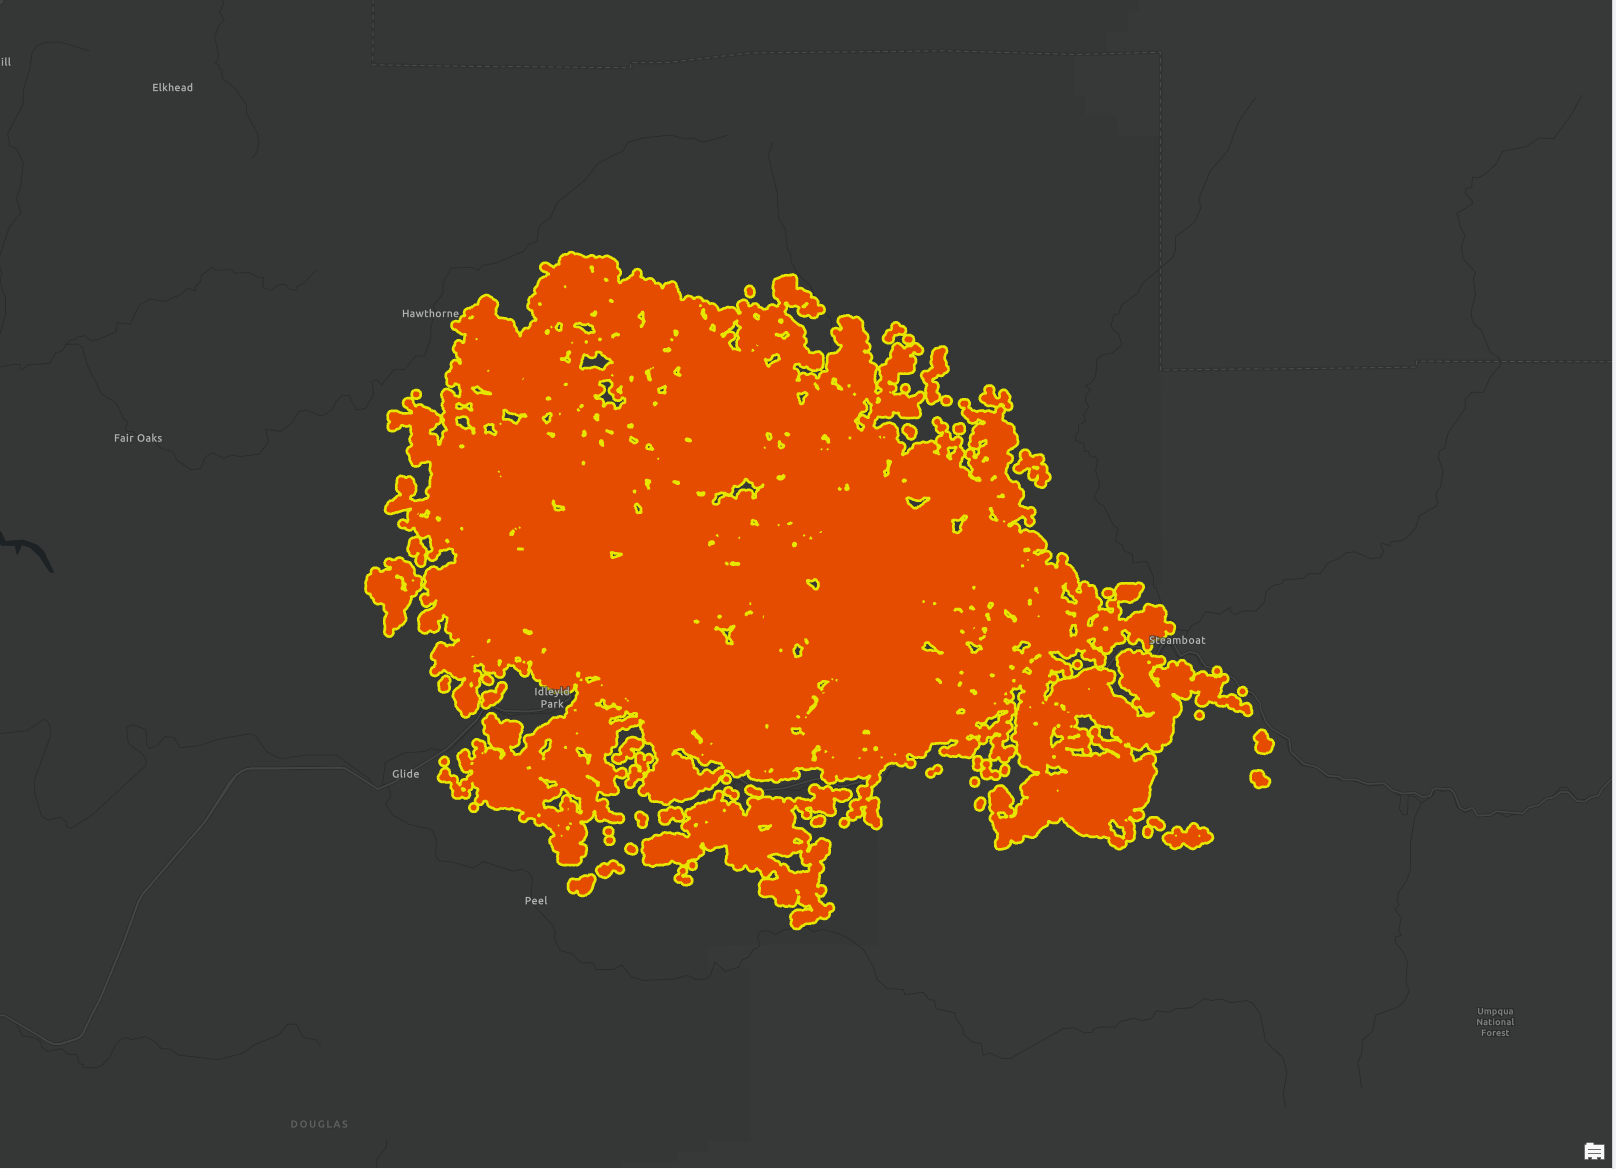

In [9]:
#arcpy.conversion.RasterToPolygon(BurntAreas,"FireItem")
#arcpy.management.MakeFeatureLayer("FireItem","fireLayer")
#fireboundarymap = gis.map()
#fireboundarymap.extent = aoi
#fireboundarymap.content.add("fireLayer_PairwiseBuffer2_DissolveBoundaries")

PATH1 = "E:\\ArcGis\\BootcampGISProjects\\2-awsAssessments\\Final Project Data\Data\\"
Image(filename = PATH1 + "FireBufferLayerImage.PNG",width=1000)

# Calculate Area
Lastly we calculate the area of the fire. We already know, due to many online sources, that the actual acreage of the fire was 120,000 to 135,000 acres depending on the source. To calculate this, we take the area of the polygons within the feature layer we created above, which is given to use in M^2, add all of them up, and convert to acres. The resulting acreage, calculated from this feature layer, is 110,776 acres. While we know that this number is low compared with the actual number of acres, it shows us the capabilities of raster analysis and how quantifiable data can be extracted from raster data

## Fire consumed 110,776 acres according to our calculations

# Conclusion
In this notebook, which was created as a learning device for raster analysis and arcpy learning, we took Sentinel-2 Data, downloaded from Copernicus, and performed analysis on it. We took rasters from before the Archie fire, during, and after, and stitched 4 together per time period. We then extracted bands and performed visual analysis, and then computed NBR using the SWIR range of the Sentinel-2 data. We normalized the values against a burn severity index, and created a colormap showing the extent and damage of the fire. Lastly we calculated the burn area of the fire using the polygons from our created feature layer